## NLTK and the Reuters Data

In [1]:
#!pip3 install nltk # run once to install

In [2]:
#nltk.download() # run to install the reuters corpus (or others)

#### Importing nltk and the Reuters Corpus

In [3]:
import nltk
from nltk.corpus import reuters

> The Reuters Corpus contains 10,788 news documents totaling 1.3 million words. The documents have been classified into 90 topics, and grouped into two sets, called "training" and "test"; thus, the text with fileid 'test/14826' is a document drawn from the test set. This split is for training and testing algorithms that automatically detect the topic of a document...

Source: [nltk book](http://www.nltk.org/book/ch02.html)

In [4]:
reuters.fileids()[0::1000] # these are the file IDs

['test/14826',
 'test/16592',
 'test/19440',
 'test/21541',
 'training/11515',
 'training/13203',
 'training/2562',
 'training/41',
 'training/5635',
 'training/7196',
 'training/8760']

To get the raw text from a file, use the `.raw` method. Other methods can be found with `dir(reuters)`

In [5]:
print(reuters.raw('test/14828')) # raw text

CHINA DAILY SAYS VERMIN EAT 7-12 PCT GRAIN STOCKS
  A survey of 19 provinces and seven cities
  showed vermin consume between seven and 12 pct of China's grain
  stocks, the China Daily said.
      It also said that each year 1.575 mln tonnes, or 25 pct, of
  China's fruit output are left to rot, and 2.1 mln tonnes, or up
  to 30 pct, of its vegetables. The paper blamed the waste on
  inadequate storage and bad preservation methods.
      It said the government had launched a national programme to
  reduce waste, calling for improved technology in storage and
  preservation, and greater production of additives. The paper
  gave no further details.
  




In [6]:
reuters.words('test/14828') # the bag of words representation

['CHINA', 'DAILY', 'SAYS', 'VERMIN', 'EAT', '7', '-', ...]

In [44]:
reuters.categories()[0::9] # example categories

['acq',
 'coffee',
 'dfl',
 'groundnut',
 'iron-steel',
 'meal-feed',
 'oilseed',
 'rand',
 'silver',
 'sunseed']

In [8]:
reuters.categories('test/14828') # the category of this particular document

['grain']

## Example Classification Task

In [9]:
#!pip3 install sklearn

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

#### Get the Text Files from the Corpus

In [11]:
def get_files(category):
    '''
    This function gets the training and 
    testing file id's for a given category.
    
    Params
    -------
    category: the category of documents from NLTK's reuters corpus
    For a list of possible categories use `reuters.categories()`
    
    Returns
    -------
    A tuple (training, test) which gives the fileids for the
    training and testing files for the given category
    
    '''
    
    training = [x for x in reuters.fileids(category) if 'training' in x]
    test = [x for x in reuters.fileids(category) if 'test' in x]
    
    return(training, test)

In [12]:
def get_dfs(categories):
    '''
    This function gets the training and 
    testing file df for classification

    
    Params
    -------
    categories: a two-element list of the categories
    
    Returns
    -------
    A tuple (train, test) of dfs
    
    '''
    
    train=pd.DataFrame()
    test=pd.DataFrame()
    
    for cat in categories:
        id_tuple = get_files(cat)
        label = cat
        text_train = [reuters.raw(f) for f in id_tuple[0]]
        text_test = [reuters.raw(f) for f in id_tuple[1]]
        tr = pd.DataFrame({'Label':label, 'Text':text_train})
        te = pd.DataFrame({'Label':label, 'Text':text_test})
        
        train=pd.concat([train,tr])
        test=pd.concat([test,te])
        
    
    return train, test

In [45]:
train, test = get_dfs(['grain', 'crude', 'coffee'])

#### Get the TF-IDF Vectors

This is the real "meat" of what's going on, and while it's only 4 lines of code they are a very important 4 lines and you shouldn't just gloss over them. This is a very oversimplified version of a typical model build. Usually we'd need to trim stop words out, use n-grams (not just words), and tune the parameters of TFIDF. Much of this can be handled by the [TfidfVectorizer()](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) function. It has a lot of parameters, and it will take a while getting comfortable with all of them. Note that TF-IDF is only one way to vectorize textual documents. It has a really intuitive interpretation, but some people don't like it.

Try playing with the parameters to see how it affects the classification as in [this](https://github.com/UI-DataScience/info490-sp16/blob/master/Week7/notebooks/intro2tc.ipynb) notebook.

In [46]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train.Text)
X_test = vectorizer.transform(test.Text)
y_train = train.Label
y_test = test.Label

#### Train the Classifier

I'm going to use a random forest since it is plug-and-play and probably familiar to many of you, but a lot of people prefer cosine similarity.

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
feature_names = vectorizer.get_feature_names() # will be useful later

forest = RandomForestClassifier(n_estimators = 100) # make the random forest object

# Fit the training data 
fit = forest.fit(X_train,y_train)

# Take the same forest and run it on the test data
output = fit.predict(X_test)

#### Inspect the Results

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

In [50]:
confusion_matrix(output, y_test)

array([[ 19,   0,   0],
       [  4, 188,   1],
       [  5,   1, 148]])

In [51]:
print(classification_report(output, y_test))

             precision    recall  f1-score   support

     coffee       0.68      1.00      0.81        19
      crude       0.99      0.97      0.98       193
      grain       0.99      0.96      0.98       154

avg / total       0.98      0.97      0.97       366



In [52]:
test['Prediction'] = output
test[test.Label != test.Prediction] # these are the ones we got wrong

,Label,Text,Prediction
123,grain,PAKISTAN UNVEILS NEW TRADE POLICY TO BOOST EXP...,crude
34,crude,1-JUN-1987 11:14:25.82\n 1-JUN-1987 11:14:2...,grain
0,coffee,INDONESIAN COMMODITY EXCHANGE MAY EXPAND\n Th...,crude
1,coffee,COLOMBIA BUSINESS ASKED TO DIVERSIFY FROM COFF...,crude
8,coffee,UGANDA PULLS OUT OF COFFEE MARKET - TRADE SOUR...,grain
12,coffee,"FRENCH AID TO TOGO TO HELP COFFEE, COCOA TREES...",grain
20,coffee,IVORY COAST WEATHER NO PROBLEM FOR 1986/87 CRO...,grain
21,coffee,INDIA RELAXES RULES FOR EXPORT PROMOTION\n Th...,crude
23,coffee,U.S. COFFEE IMPORT REPORTING SYSTEM QUESTIONED...,crude
26,coffee,COLOMBIA OPENS COFFEE REGISTRATIONS - LDN TRAD...,grain


This performed pretty well but we missed a lot of the true coffee documents. Why might this be? 

Some things I didn't check, that you should:

* How many documents were used to train, how many to test (since we didn't split the data ourselves)
* How *imbalanced* were the classes? I.e. if we had way more crude articles than grain, what was our sensitivity/specificity
* Is TF-IDF appropriate for this data? Would the model have performed better without the IDF weights?
* Others

#### Feature Importances

My favorite part of doing text analysis with tree algorithms is the feature importances. You can actually see which words were indicative of an article being from one class or the other, and how much your model would have suffered had we not included those words in the analysis. It makes for an awesome visualization when presenting your results to non-technical audiences, because the interpretation is very straightforward.

In [53]:
%matplotlib inline

In [54]:
importances = fit.feature_importances_
imp_df = pd.DataFrame({'Feature':feature_names, 'Importance':importances})
imp_df = imp_df.sort('Importance', ascending=False).head(10)
imp_df

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Feature,Importance
6490,oil,0.054349
2331,coffee,0.028949
4422,grain,0.025167
10017,wheat,0.022757
2772,crude,0.020405
1584,barrels,0.019958
9412,tonnes,0.018249
1052,agriculture,0.013805
6912,petroleum,0.012670
2657,corn,0.012451


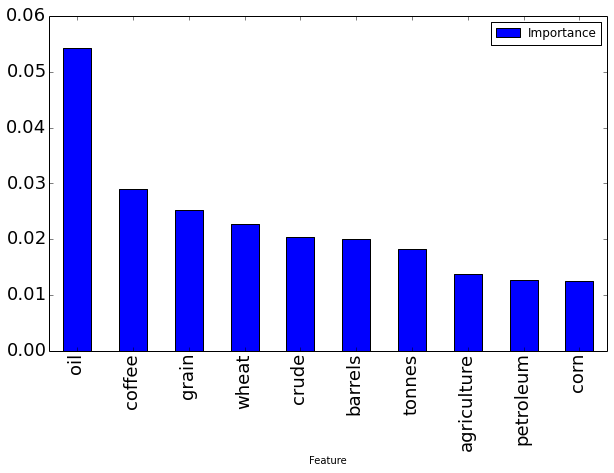

In [55]:
imp_df.plot(kind='bar', 
            x='Feature', 
            figsize=(10,6),
            fontsize=18)